In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import  RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV

## Data Exploration

In [2]:
data=pd.read_csv('GUIDE_Test.csv',nrows=1500000)

In [3]:
data.shape

(1500000, 46)

In [4]:
data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

In [5]:
data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [6]:
data.isna().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques        833682
IncidentGrade               0
ActionGrouped         1499263
ActionGranular        1499263
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        1484853
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          1488656
FileName                    0
FolderPath

In [7]:
mis_value=[]
missing = ['MitreTechniques','ActionGrouped','ActionGranular','EmailClusterId','ThreatFamily','ResourceType','Roles','AntispamDirection','SuspicionLevel','LastVerdict']
for i in missing:
    res=abs(data[i].count() - data[i].isna().sum())
    count=data[i].count()
    mis_value.append((i , count ,res))
pd.DataFrame(mis_value,columns=['Columns name','Present values','Missing value'])

,Columns name,Present values,Missing value
0,MitreTechniques,666318,167364
1,ActionGrouped,737,1498526
2,ActionGranular,737,1498526
3,EmailClusterId,15147,1469706
4,ThreatFamily,11344,1477312
5,ResourceType,1071,1497858
6,Roles,39555,1420890
7,AntispamDirection,27924,1444152
8,SuspicionLevel,234455,1031090
9,LastVerdict,358849,782302


In [8]:
data.dtypes

Id                      int64
OrgId                   int64
IncidentId              int64
AlertId                 int64
Timestamp              object
DetectorId              int64
AlertTitle              int64
Category               object
MitreTechniques        object
IncidentGrade          object
ActionGrouped          object
ActionGranular         object
EntityType             object
EvidenceRole           object
DeviceId                int64
Sha256                  int64
IpAddress               int64
Url                     int64
AccountSid              int64
AccountUpn              int64
AccountObjectId         int64
AccountName             int64
DeviceName              int64
NetworkMessageId        int64
EmailClusterId        float64
RegistryKey             int64
RegistryValueName       int64
RegistryValueData       int64
ApplicationId           int64
ApplicationName         int64
OAuthApplicationId      int64
ThreatFamily           object
FileName                int64
FolderPath

## EDA

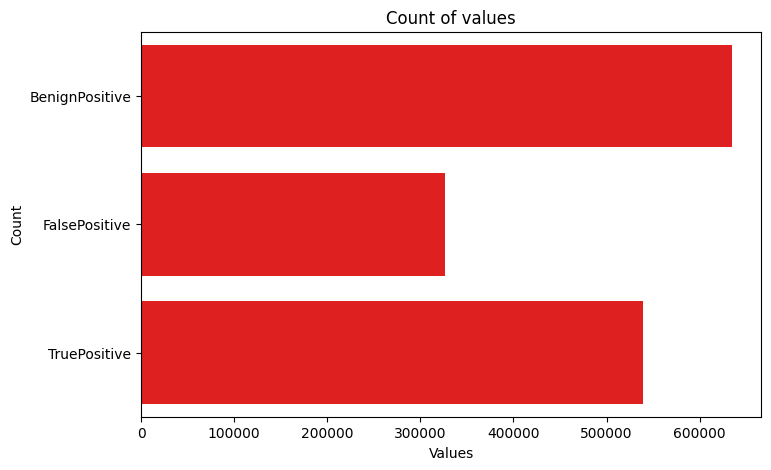

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(data=data['IncidentGrade'],color='r')
plt.title('Count of values')
plt.xlabel('Values')
plt.ylabel('Count')
plt.show()

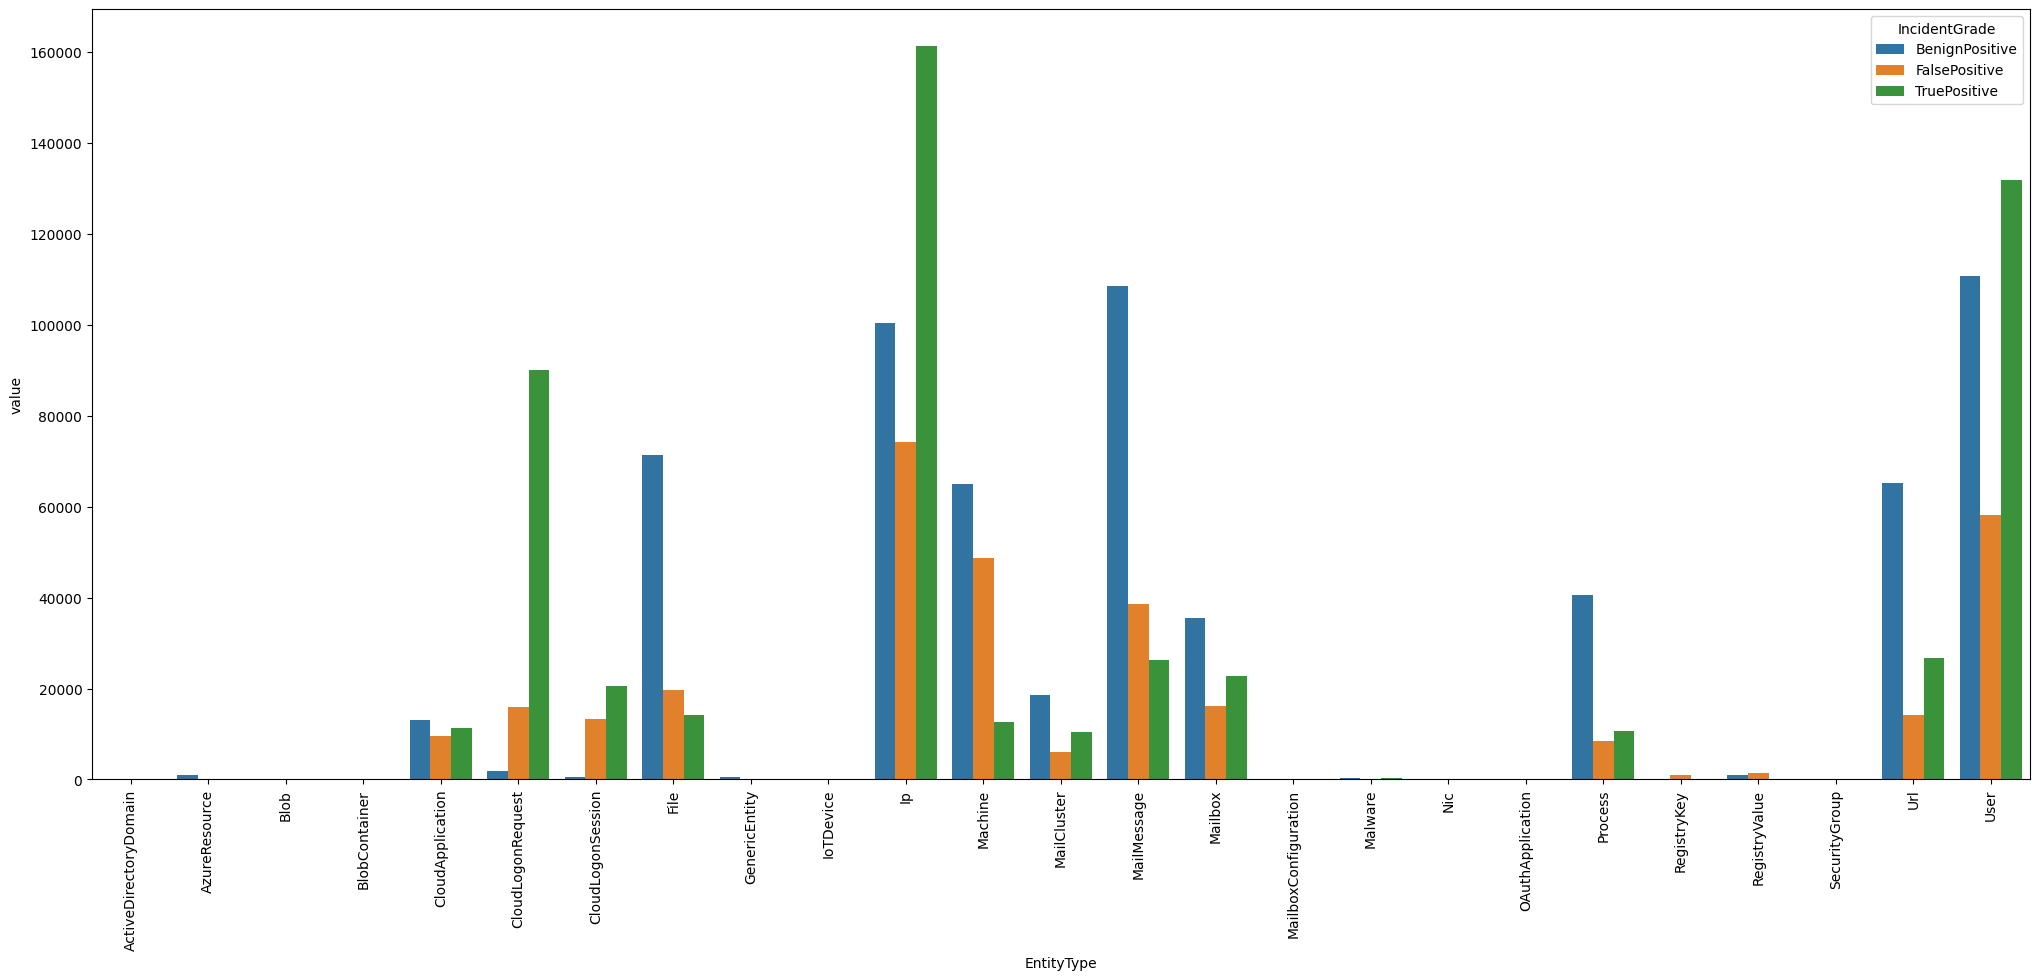

In [10]:
grpd_data=data.groupby(['EntityType','IncidentGrade']).size().reset_index(name='value')
plt.figure(figsize=(25,10))
sns.barplot(data=grpd_data,x='EntityType',y='value',hue='IncidentGrade')
plt.xticks(rotation=90)
plt.show()

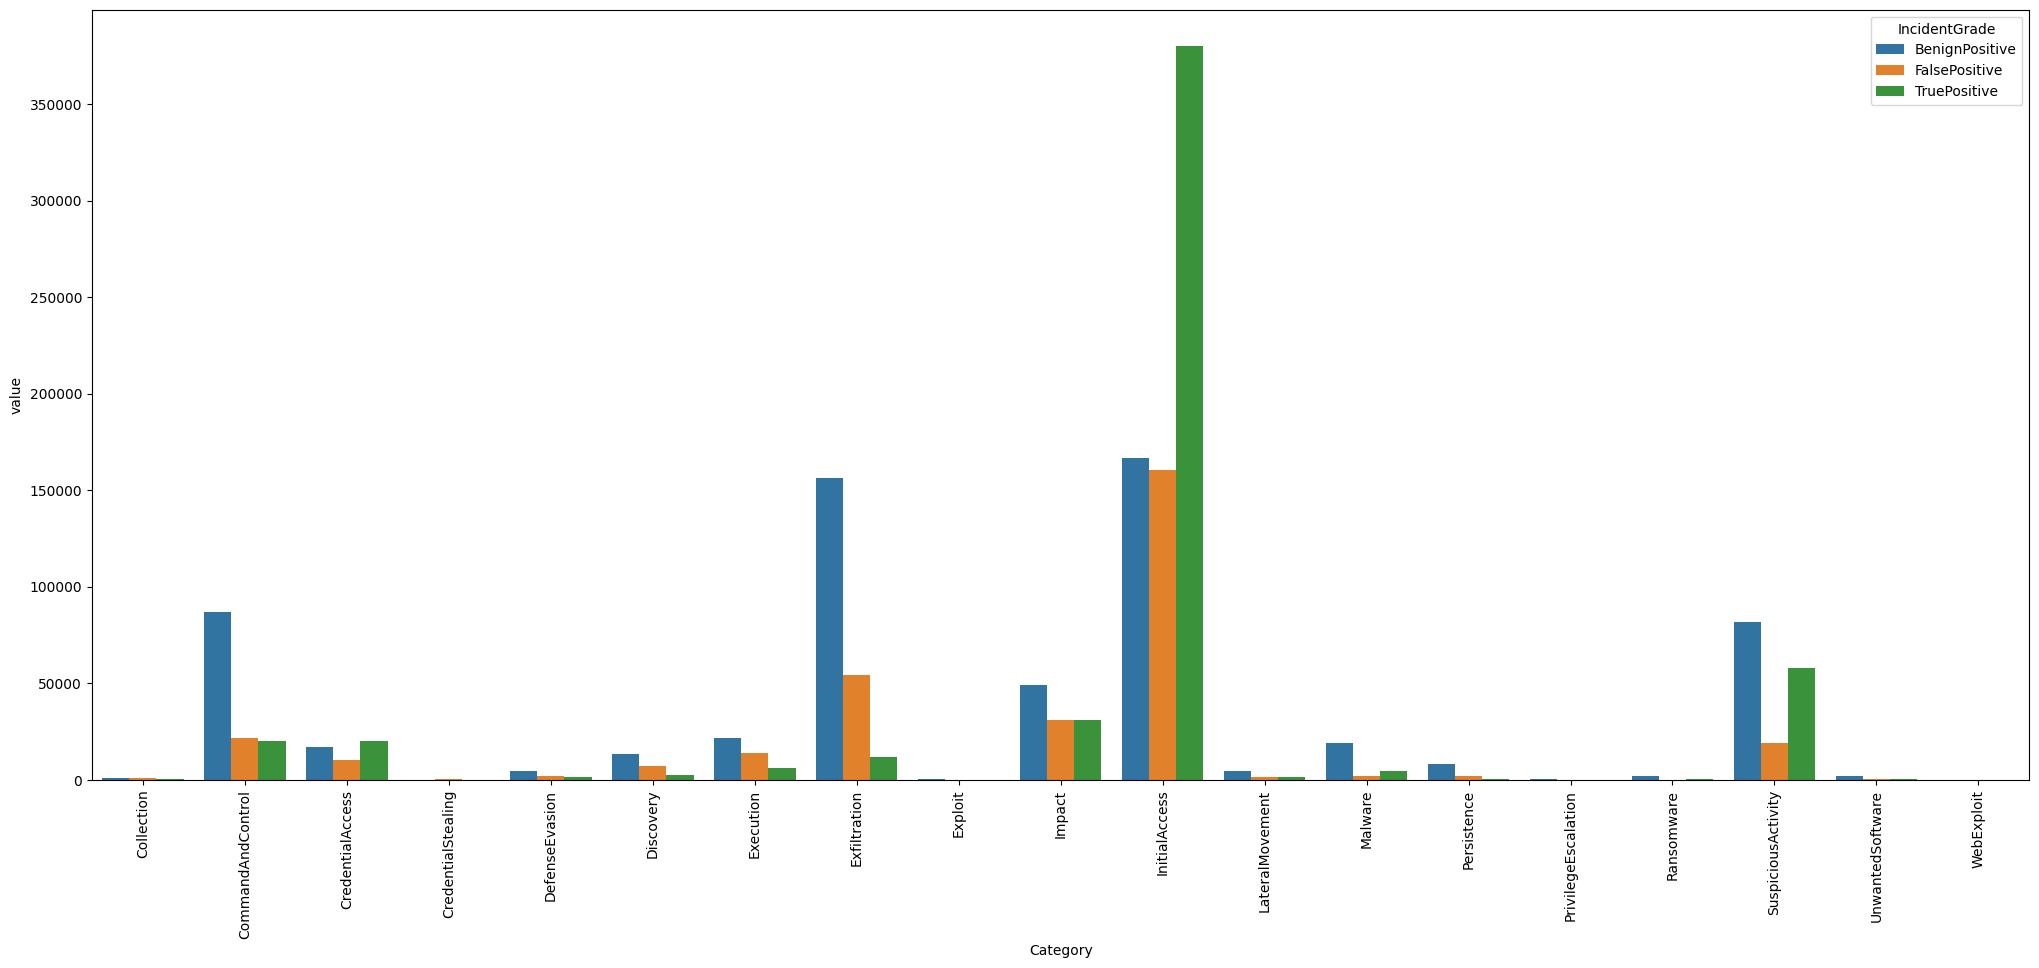

In [11]:
grpd_data_2=data.groupby(['Category','IncidentGrade']).size().reset_index(name='value')
plt.figure(figsize=(25,10))
sns.barplot(data=grpd_data_2,x='Category',y='value',hue='IncidentGrade')
plt.xticks(rotation=90)
plt.show()

## Feature Engineering

### Adding new feature

In [12]:
data['Timestamp']=pd.to_datetime(data['Timestamp'])
data['Day']=data['Timestamp'].dt.day
data['Month']=data['Timestamp'].dt.month
data['Hour']=data['Timestamp'].dt.hour
data['Time']=data['Timestamp'].dt.minute
data.drop('Timestamp',axis=1,inplace=True)

## Handeling missing values

In [13]:
data.isna().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques        833682
IncidentGrade               0
ActionGrouped         1499263
ActionGranular        1499263
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        1484853
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          1488656
FileName                    0
FolderPath                  0
ResourceId

In [14]:
data=data.drop(columns=['Id','MitreTechniques','ActionGrouped','ActionGranular','EmailClusterId','ThreatFamily','ResourceType','Roles','Usage','AntispamDirection','SuspicionLevel','LastVerdict'],axis=1)

In [15]:
data.isna().sum()

OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Day                   0
Month                 0
Hour                  0
Time                  0
dtype: int64

In [16]:
data.dtypes

OrgId                  int64
IncidentId             int64
AlertId                int64
DetectorId             int64
AlertTitle             int64
Category              object
IncidentGrade         object
EntityType            object
EvidenceRole          object
DeviceId               int64
Sha256                 int64
IpAddress              int64
Url                    int64
AccountSid             int64
AccountUpn             int64
AccountObjectId        int64
AccountName            int64
DeviceName             int64
NetworkMessageId       int64
RegistryKey            int64
RegistryValueName      int64
RegistryValueData      int64
ApplicationId          int64
ApplicationName        int64
OAuthApplicationId     int64
FileName               int64
FolderPath             int64
ResourceIdName         int64
OSFamily               int64
OSVersion              int64
CountryCode            int64
State                  int64
City                   int64
Day                    int32
Month         

In [17]:
data.to_csv('Test_sample.csv')

## Encoding

In [18]:
encoder=LabelEncoder()
for i in data.columns:
    if data[i].dtype=='object':
        data[i]=encoder.fit_transform(data[i])

In [19]:
data.head()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Hour,Time
0,657,11767,87199,524,563,11,0,24,0,98799,...,3586,5,66,242,1445,10630,4,6,22,56
1,3,91158,632273,2,2,1,0,11,0,1239,...,3586,0,0,242,1445,10630,3,6,12,58
2,145,32247,131719,2932,10807,11,0,19,1,98799,...,3586,5,66,242,1445,10630,8,6,3,20
3,222,15294,917686,0,0,10,1,6,1,98799,...,3586,5,66,242,1445,10630,12,6,12,7
4,363,7615,5944,27,18,5,0,24,0,98799,...,3586,5,66,242,1445,10630,6,6,17,42


### Coorelation map

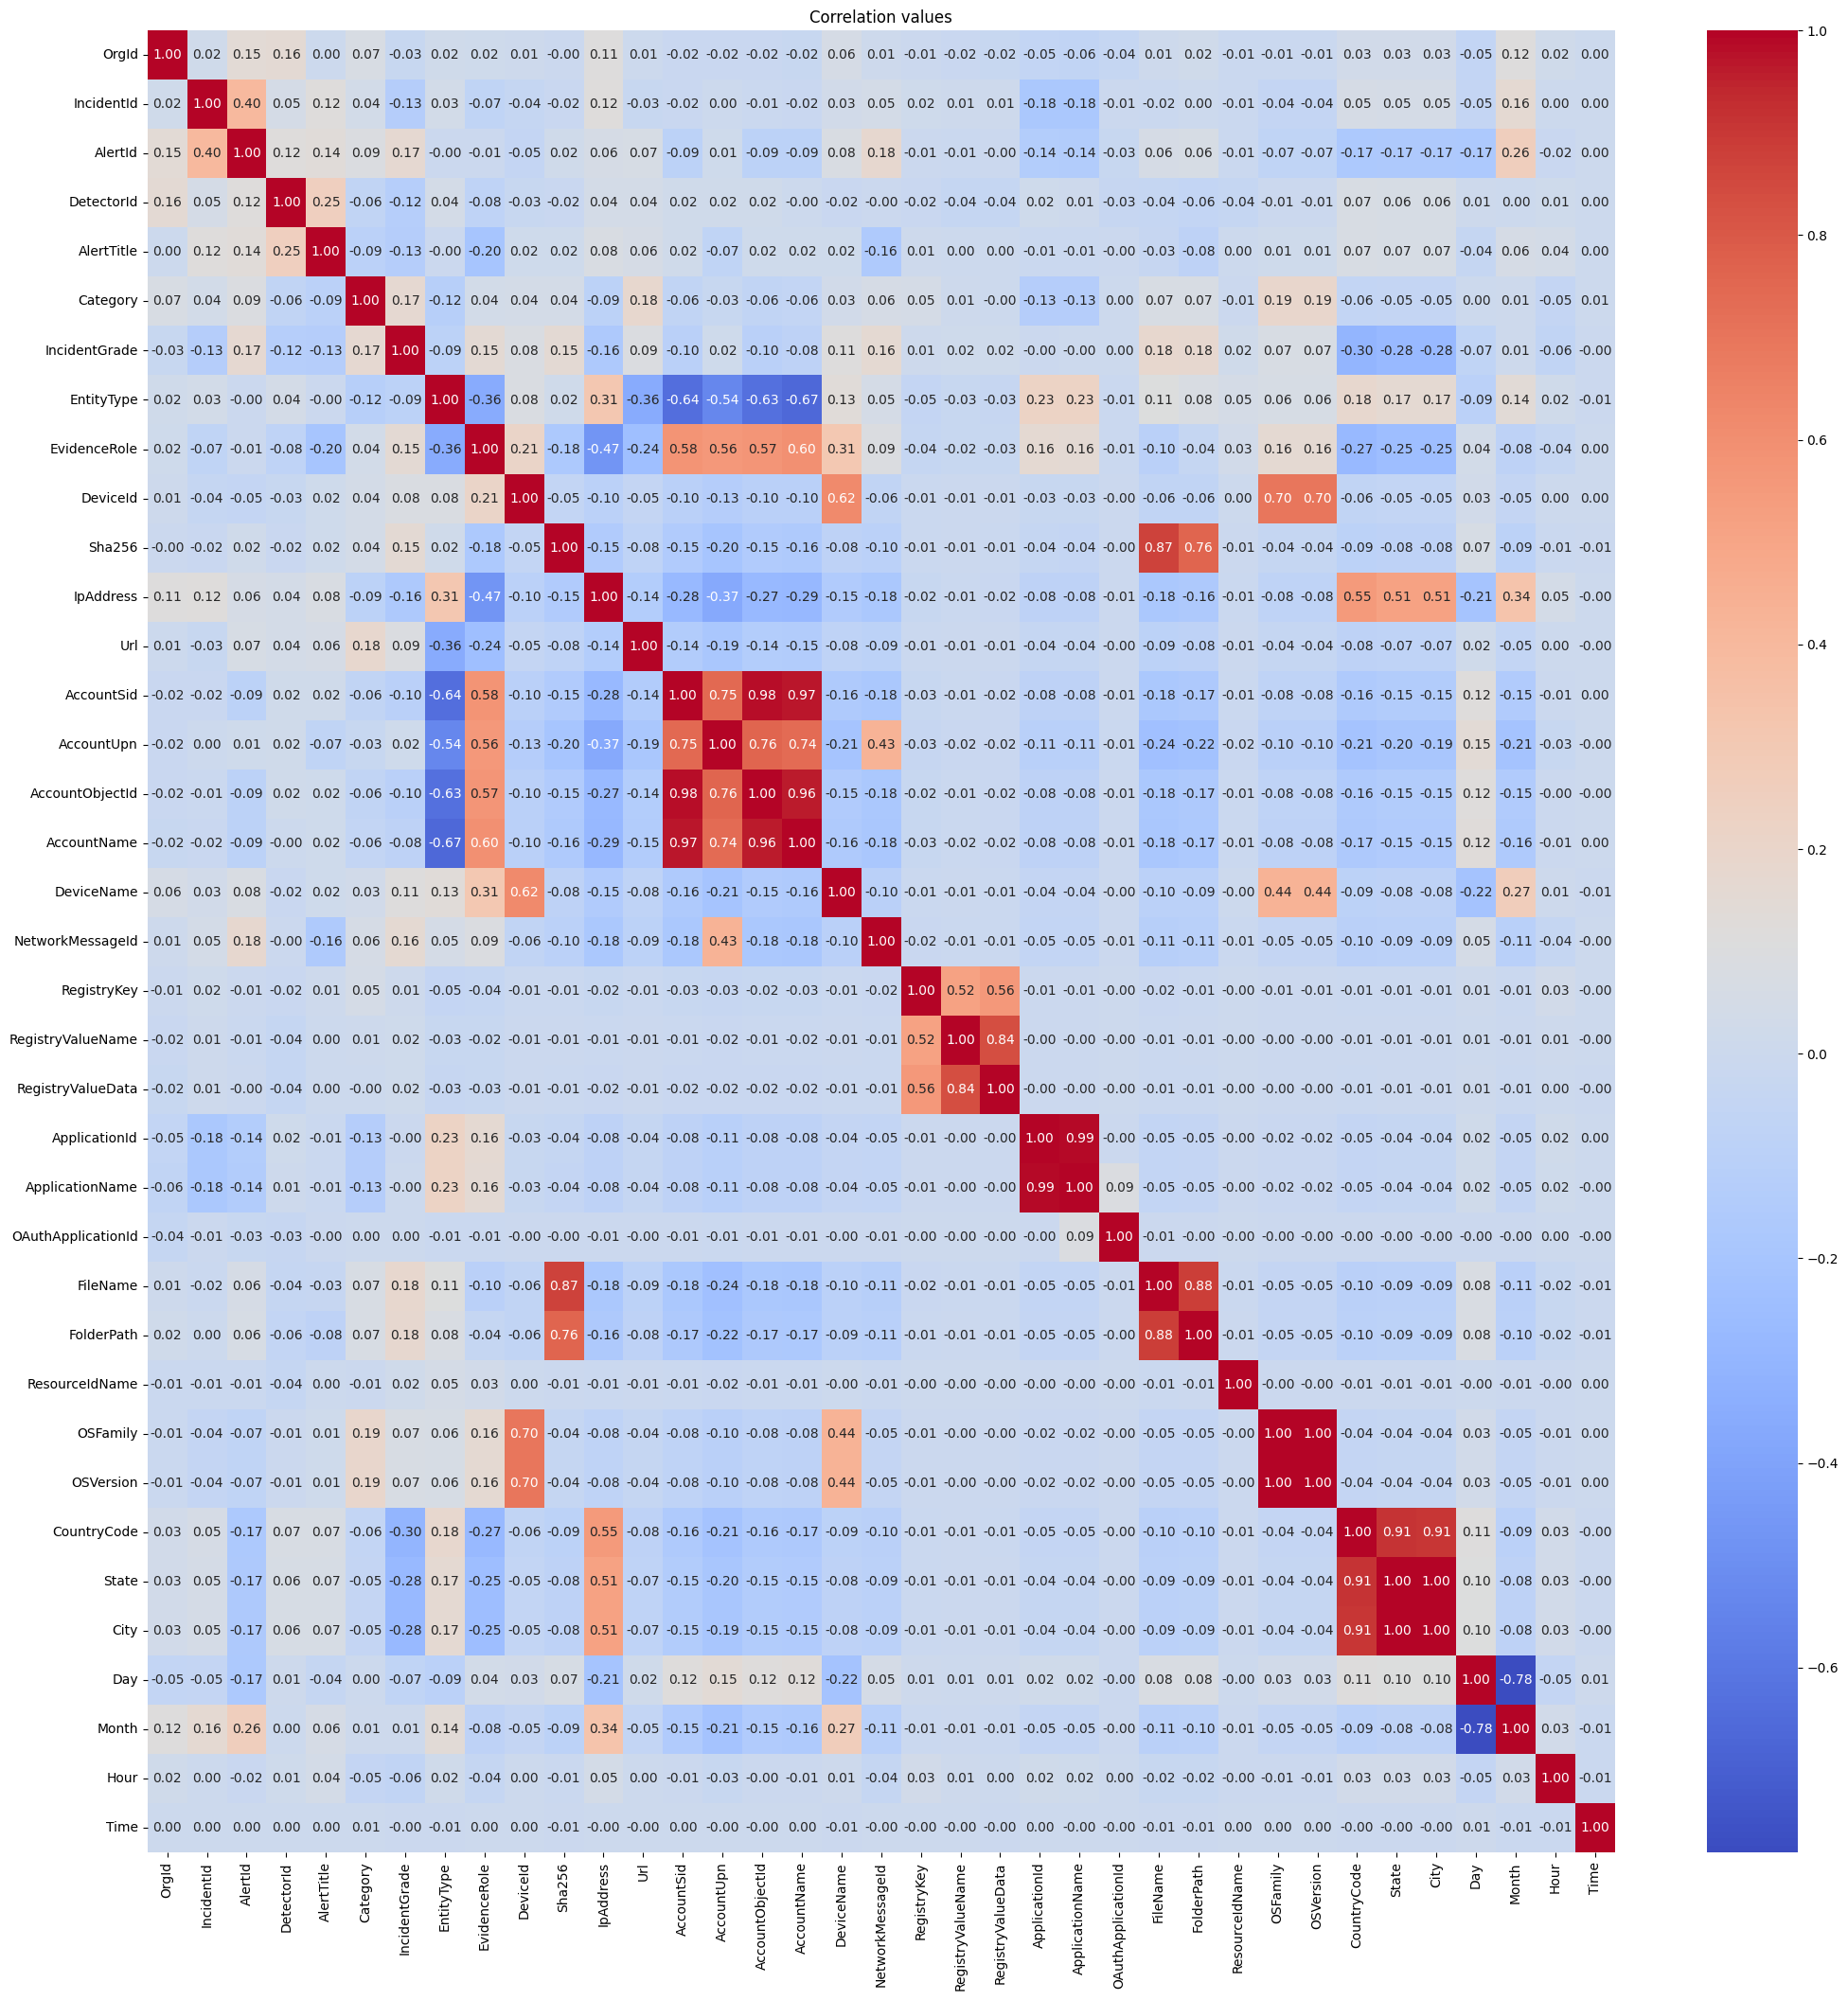

In [20]:
plt.figure(figsize=(25,25))
sns.heatmap(data=data.corr(),cmap='coolwarm',fmt='.2f',annot=True)
plt.title('Correlation values')
plt.show()

In [21]:
data=data.drop(columns=['AccountSid','AccountUpn','AccountObjectId','AccountName','RegistryValueName','RegistryValueData','ApplicationId','ApplicationName','FileName','FolderPath','OSFamily','OSVersion','CountryCode','Sha256','State','City','Hour','Time'],axis=1)

In [22]:
data.columns

Index(['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'IpAddress', 'Url', 'DeviceName', 'NetworkMessageId', 'RegistryKey',
       'OAuthApplicationId', 'ResourceIdName', 'Day', 'Month'],
      dtype='object')

## Data Splitting

In [23]:
x=data.drop('IncidentGrade',axis=1).values
y=data['IncidentGrade']

In [24]:
x

array([[   657,  11767,  87199, ...,   3586,      4,      6],
       [     3,  91158, 632273, ...,   3586,      3,      6],
       [   145,  32247, 131719, ...,   3586,      8,      6],
       ...,
       [     1,    283, 510253, ...,   3586,      2,      6],
       [   205,  14616, 115301, ...,   3586,      8,      6],
       [    89,    277,   1074, ...,   3586,     14,      6]])

## SMOTE

In [25]:
ovr_sam=RandomOverSampler()
x_res,y_res=ovr_sam.fit_resample(x,y)


In [26]:
y_res.value_counts()

IncidentGrade
0    634437
1    634437
2    634437
Name: count, dtype: int64

## Train Test Split

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,random_state=0,test_size=0.25)

## Model

### XGBOOSTING

In [28]:
xgb=xgboost.XGBClassifier()
xgb.fit(x_train,y_train)
xgb_score=xgb.score(x_test,y_test)
print('Score : ',xgb_score*100)

Score :  92.34744487503887


In [29]:
xgb_para={
    'n_estimators':[110,140,150,180,200],
    'learning_rate':[0.001,0.01,0.1,1],
    'max_depth':[5,8,10,12,15,18,20]
}

In [30]:
xgb_tunning=RandomizedSearchCV(estimator=xgboost.XGBClassifier(),param_distributions=xgb_para,cv=5)
xgb_tunning.fit(x_train,y_train)
xgb_pre=xgb_tunning.predict(x_test)
acc_xgboost=accuracy_score(y_test,xgb_pre)
pre_xgboost=precision_score(y_test,xgb_pre,average='macro')
recall_xgboost=recall_score(y_test,xgb_pre,average='macro')
f1_xgboost=f1_score(y_test,xgb_pre,average='macro')

C:\Users\ukesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [31]:
pd.DataFrame({'Model' : 'XGBClassifier', 'Accuracy' : acc_xgboost*100, 'Recall' : recall_xgboost*100, 'Precision' : pre_xgboost*100 , 'f1_score' : f1_xgboost*100},index=[0])

,Model,Accuracy,Recall,Precision,f1_score
0,XGBClassifier,99.025068,99.02507,99.025847,99.025007


In [32]:
pd.DataFrame(xgb_tunning.best_params_,index=[0])

,n_estimators,max_depth,learning_rate
0,200,18,1
